# Custom loss functions

One can specify additional loss functions to perform deformable/affine registration. 

In [ ]:
# %load_ext autoreload
# %autoreload 2
from fireants.io import Image, BatchedImages
from fireants.registration.affine import AffineRegistration
from fireants.registration.greedy import GreedyRegistration
import matplotlib.pyplot as plt
from time import time

import torch
from torch import nn

In [2]:
# load images and masks
# here we're combining the image loading and batch loading
fixed_image = BatchedImages(Image.load_file("lung_images/01_Fixed.nii.gz"))
moving_image = BatchedImages(Image.load_file("lung_images/01_Moving.nii.gz"))

In [3]:
fixed_mask = BatchedImages(Image.load_file("lung_masks/01_Fixed.nii.gz"))
moving_mask = BatchedImages(Image.load_file("lung_masks/01_Moving.nii.gz"))

## Dice loss
 
Here we define a simple custom dice loss function, in practice, it can be more nuanced than that. 
Custom loss functions are defined as a subclass of the `nn.Module` class in PyTorch.

In [4]:
class DiceLossModule(nn.Module):
    # Dice loss in the form of nn Module to pass into affine step 
    # assumes a single class only (for brevity)
    def __init__(self):
        super().__init__()
    
    def forward(self, moved_seg, fixed_seg, *args, **kwargs):
        # flatten the images into [B, N] and the compute dice score
        moved_flat = moved_seg.flatten(1)
        fixed_flat = fixed_seg.flatten(1)
        num = 2*(moved_flat*fixed_flat).sum(1)
        den = moved_flat.sum(1) + fixed_flat.sum(1)
        return 1 - (num/den).mean()

In [5]:
affine = AffineRegistration([6, 4, 2, 1], [200, 100, 50, 20], fixed_mask, moving_mask, \
           loss_type='custom', custom_loss=DiceLossModule(), optimizer='Adam', \
            optimizer_lr=3e-3, optimizer_params={}, cc_kernel_size=5)
aff_start = time()
moved_mask = affine.optimize(save_transformed=True)[-1]
aff_end = time()

/data/rohitrango/code/fireants/fireants/utils/imageutils.py:108: UserWarning: operator() sees varying value in profiling, ignoring and this should be handled by GUARD logic (Triggered internally at ../torch/csrc/jit/codegen/cuda/parser.cpp:3668.)
  image_smooth = separable_filtering(image, gaussians)
/data/rohitrango/code/fireants/fireants/registration/affine.py:82: UserWarning: operator() profile_node %70 : int[] = prim::profile_ivalue[profile_failed="varying profile values"](%s.1)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  moving_image_blur = separable_filtering(moving_arrays, gaussians)
scale: 1, iter: 19/20, loss: 0.151593: 100%|█████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.36it/s]


In [6]:
print("Runtime: {:04f} seconds.".format(aff_end - aff_start))

Runtime: 3.259582 seconds.


In [7]:
# note that the fixed and moving images have different shapes
fixed_mask.shape, moving_mask.shape

(torch.Size([1, 1, 423, 468, 518]), torch.Size([1, 1, 512, 486, 562]))

Text(0.5, 1.0, 'Moving Mask')

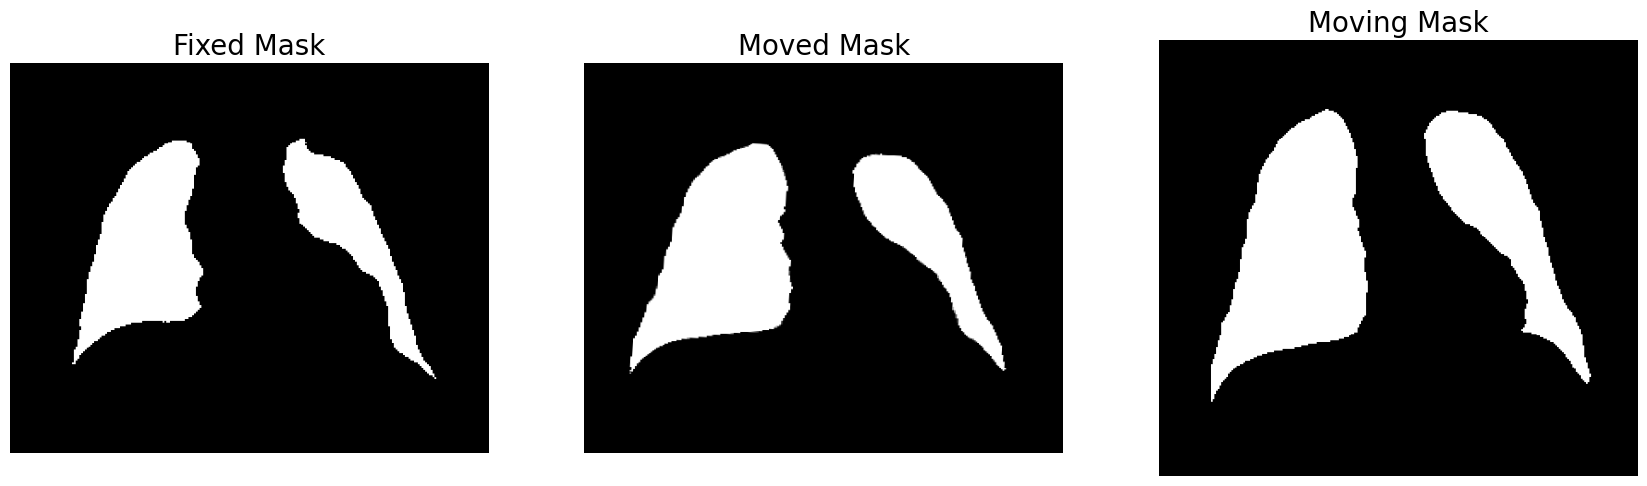

In [8]:
# Visualize the masks
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax[0].imshow(fixed_mask()[0, 0, :, 200].cpu().numpy(), 'gray'); ax[0].invert_yaxis(); ax[0].axis('off')
ax[1].imshow(moved_mask[0, 0, :, 200].detach().cpu().numpy(), 'gray'); ax[1].invert_yaxis(); ax[1].axis('off')
ax[2].imshow(moving_mask()[0, 0, :, 200].cpu().numpy(), 'gray'); ax[2].invert_yaxis(); ax[2].axis('off')
# set titles
ax[0].set_title("Fixed Mask", fontsize=20)
ax[1].set_title("Moved Mask", fontsize=20)
ax[2].set_title("Moving Mask", fontsize=20)

Moved mask already looks pretty good! Let's run deformable registration now.

## Deformable registration

In [9]:
affine_matrix = affine.get_affine_matrix()
del affine, fixed_mask, moving_mask
torch.cuda.empty_cache()

In [11]:
deformable = GreedyRegistration(scales=[6, 4, 2, 1], iterations=[200, 150, 75, 25], 
                        fixed_images=fixed_image, moving_images=moving_image,
                        cc_kernel_size=5, 
                        deformation_type='compositive',
                        max_tolerance_iters=1000,
                        smooth_grad_sigma=6, smooth_warp_sigma=0.4, 
                        optimizer='Adam',
                        optimizer_lr=0.25, init_affine=affine_matrix)

In [12]:
start = time()
deformable.optimize(save_transformed=False)
end = time()

scale: 1, iter: 24/25, loss: -0.930898: 100%|████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.11it/s]


In [13]:
print("Runtime: {:04f} seconds.".format(end - start))

Runtime: 36.172794 seconds.


In [14]:
moved_image = deformable.evaluate(fixed_image, moving_image)

Text(0.5, 1.0, 'Moving Mask')

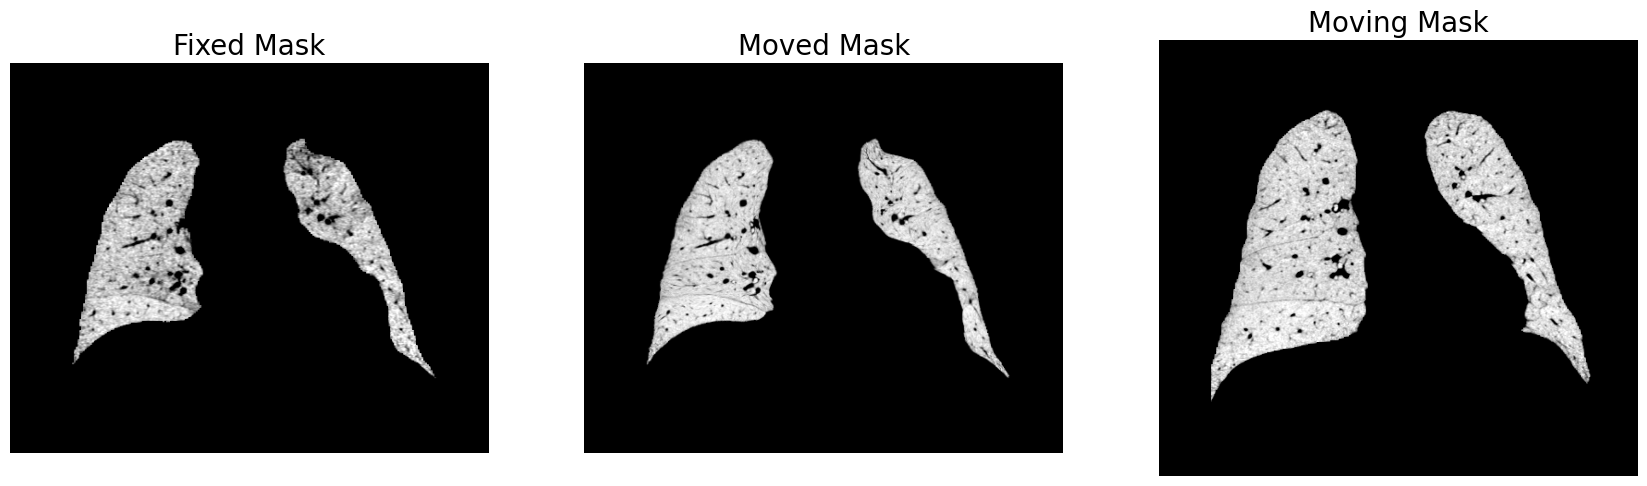

In [15]:
# Visualize the masks
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax[0].imshow(fixed_image()[0, 0, :, 200].cpu().numpy(), 'gray'); ax[0].invert_yaxis(); ax[0].axis('off')
ax[1].imshow(moved_image[0, 0, :, 200].detach().cpu().numpy(), 'gray'); ax[1].invert_yaxis(); ax[1].axis('off')
ax[2].imshow(moving_image()[0, 0, :, 200].cpu().numpy(), 'gray'); ax[2].invert_yaxis(); ax[2].axis('off')
# set titles
ax[0].set_title("Fixed Mask", fontsize=20)
ax[1].set_title("Moved Mask", fontsize=20)
ax[2].set_title("Moving Mask", fontsize=20)

Text(0.5, 1.0, 'Moving Mask')

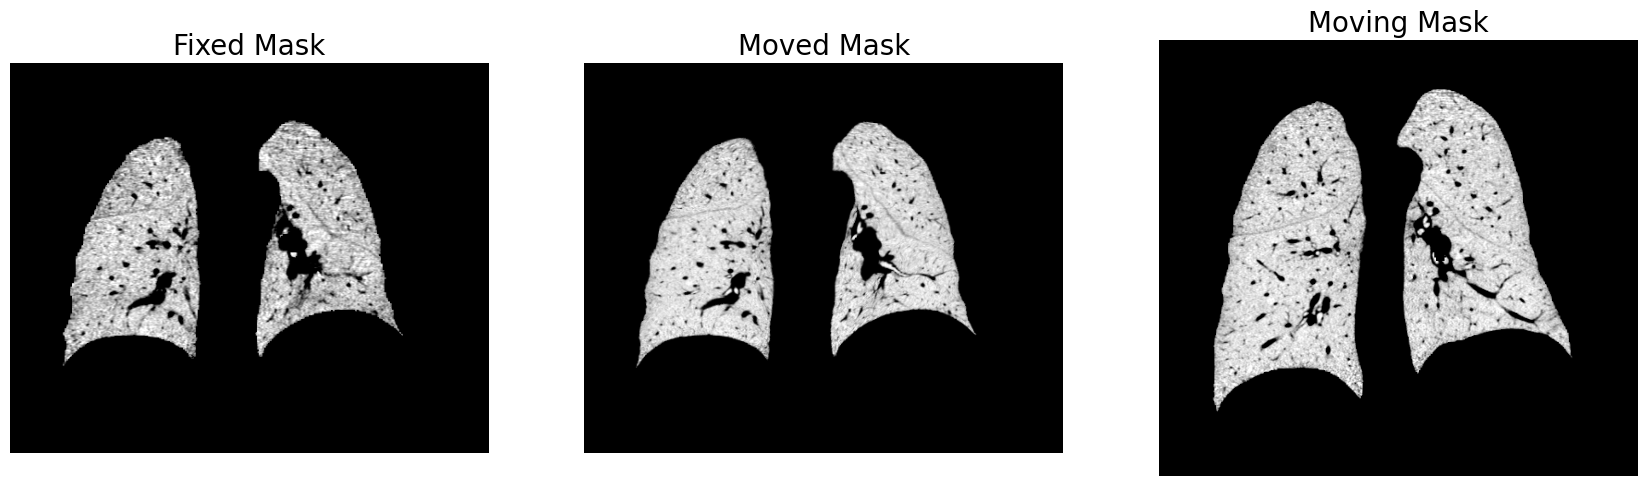

In [17]:
# Visualize the masks
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax[0].imshow(fixed_image()[0, 0, :, 300].cpu().numpy(), 'gray'); ax[0].invert_yaxis(); ax[0].axis('off')
ax[1].imshow(moved_image[0, 0, :, 300].detach().cpu().numpy(), 'gray'); ax[1].invert_yaxis(); ax[1].axis('off')
ax[2].imshow(moving_image()[0, 0, :, 300].cpu().numpy(), 'gray'); ax[2].invert_yaxis(); ax[2].axis('off')
# set titles
ax[0].set_title("Fixed Mask", fontsize=20)
ax[1].set_title("Moved Mask", fontsize=20)
ax[2].set_title("Moving Mask", fontsize=20)